<div style="background-color: white; color: black; font-family: 'Times New Roman', serif; padding: 50px; max-width: 450px; margin: auto; border: 1px solid #ccc; box-shadow: 0 0 10px rgba(0,0,0,0.1);">
  <div align="center">
    <img src="Imagenes/ugr_escudo_sin.png" alt="Escudo UGR" style="height: 120px;"><br><br>
    <h2 style="margin-bottom: 0;">Universidad de Granada</h2>
    <h3 style="margin-top: 0;">TRABAJO FIN DE GRADO</h3>
    <p style="font-variant: small-caps; font-size: 14px;">
      Doble Grado en Ingeniería Informática y Administración y Dirección de Empresas
    </p>
    <hr style="width: 60%; border: 1px solid black;">
    <h2 style="font-size: 20px;">
      Análisis y Optimización de<br>
      Rutas Aéreas Comerciales<br>
      mediante Ciencia de Datos
    </h2>
    <hr style="width: 60%; border: 1px solid black;">
    <br>
    <p><strong>Autor</strong><br>José Antonio Fernández Aranda</p>
    <p><strong>Director</strong><br>Jorge Casillas Barranquero</p>
    <p><strong>Análisis de Vuelos Nacionales</strong><br></p>
    <br><br>
    <div style="display: flex; justify-content: center; align-items: center; gap: 80px; flex-wrap: wrap;">
      <img src="https://etsiit.ugr.es/sites/centros/etsiit/public/template-extra/etsiit-logo.png" alt="Logo ETSIIT" style="height: 100px;">
      <img src="Imagenes/logo_decsai.png" alt="Logo DECSAI" style="height: 100px;">
    </div>
    <br>
    <p style="font-size: 14px;">
      Escuela Técnica Superior de Ingenierías Informática y de Telecomunicación<br>
      —<br>
      Granada, a 8 de junio de 2025
    </p>
  </div>
</div>

## Análisis exploratorio de vuelos
Este notebook realiza un análisis inicial sobre un conjunto de datos simulados que representan trayectorias aéreas. Cada fila contiene un punto de posición de un vuelo, con coordenadas, altitud, velocidad, y metadatos adicionales como país de origen y código de vuelo.

## 1. Carga de datos y librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")


## 2. Resumen general del conjunto de datos

In [2]:
df = pd.read_csv("flights_dataset_realistic_dirty.csv", parse_dates=["timestamp"])
df.head()


flight_id           timestamp   latitude  longitude  altitude  velocity  \
0   FL00000 2023-03-22 10:02:00  51.143576  -0.061900  10639.53    208.90   
1   FL00000 2023-03-22 10:02:30  51.619441  -0.410063  10229.03    257.24   
2   FL00000 2023-03-22 10:03:00  51.555010  -0.410313  10472.87    289.48   
3   FL00000 2023-03-22 10:03:30  51.121954  -0.520857  10218.94    282.51   
4   FL00000 2023-03-22 10:04:00  51.705705  -0.248547  10469.63    283.88   

  callsign      origin_country  
0   jjdAXQ        Sierra Leone  
1      NaN          Tajikistan  
2   nnixCp                 NaN  
3   iyMPev               Chile  
4   BebnOT  Dominican Republic

In [3]:
print(f"Filas totales: {df.shape[0]:,}")
print(f"Columnas: {df.shape[1]}")
df.info()


Filas totales: 294,500
Columnas: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294500 entries, 0 to 294499
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   flight_id       294500 non-null  object        
 1   timestamp       294500 non-null  datetime64[ns]
 2   latitude        288623 non-null  float64       
 3   longitude       288623 non-null  float64       
 4   altitude        288541 non-null  float64       
 5   velocity        288687 non-null  float64       
 6   callsign        288488 non-null  object        
 7   origin_country  288603 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 18.0+ MB


## Análisis de valores faltantes

In [4]:
faltantes = df.isnull().sum()
porcentaje = (faltantes / len(df) * 100).round(2)

faltantes_df = pd.DataFrame({
    'Valores faltantes': faltantes,
    'Porcentaje (%)': porcentaje
})

faltantes_df[faltantes_df["Valores faltantes"] > 0]


Valores faltantes  Porcentaje (%)
latitude                     5877            2.00
longitude                    5877            2.00
altitude                     5959            2.02
velocity                     5813            1.97
callsign                     6012            2.04
origin_country               5897            2.00

### Visualización de faltantes

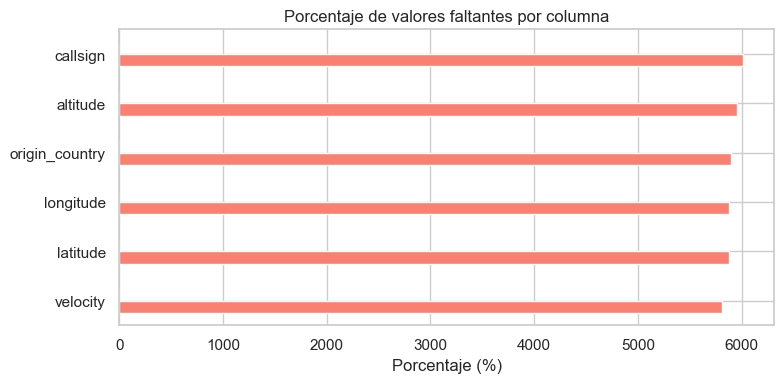

In [5]:
faltantes_df[faltantes_df["Valores faltantes"] > 0].sort_values(by="Porcentaje (%)", ascending=True).plot.barh(
    figsize=(8, 4), color="salmon", legend=False
)
plt.title("Porcentaje de valores faltantes por columna")
plt.xlabel("Porcentaje (%)")
plt.tight_layout()
plt.show()

### Detección de valores extremos (coordenadas)

In [8]:
print("Latitud - min:", df['latitude'].min(), "| max:", df['latitude'].max())

print("Longitud - min:", df['longitude'].min(), "| max:", df['longitude'].max())

df_extremos = df[
    (df['latitude'] < -90) | (df['latitude'] > 90) |
    (df['longitude'] < -180) | (df['longitude'] > 180)
]


Latitud - min: 25.568656 | max: 64.820698
Longitud - min: -23.890022 | max: 19.928654


### Filtrar extremos inválidos

In [9]:
df = df[
    (df['latitude'].between(-90, 90)) &
    (df['longitude'].between(-180, 180))
]

### Análisis de velocidad y altitud

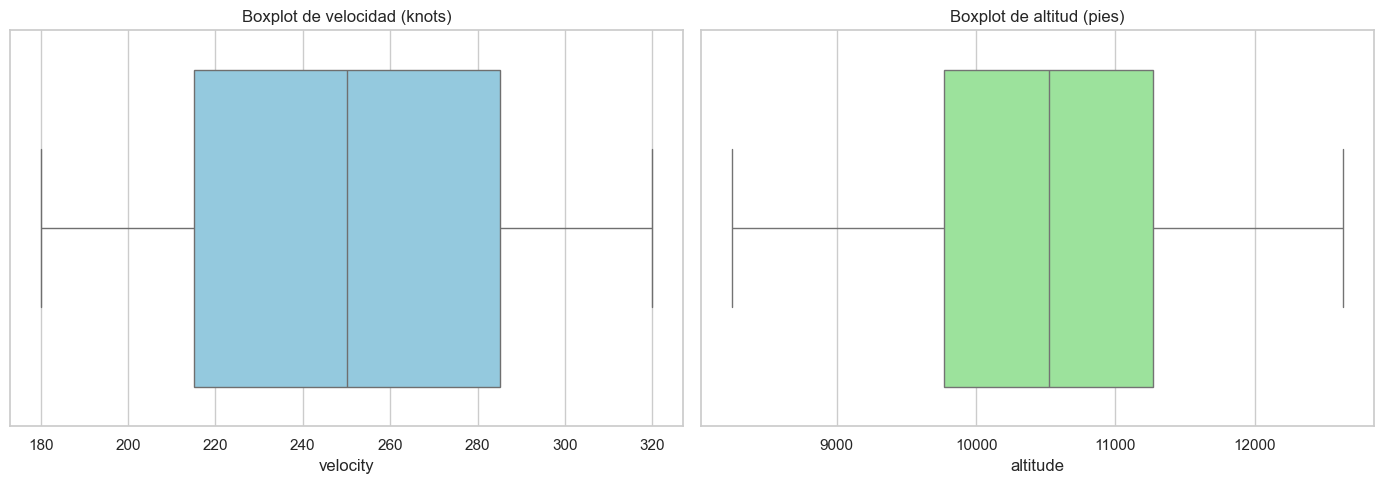

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x=df['velocity'], ax=axs[0], color='skyblue')
axs[0].set_title('Boxplot de velocidad (knots)')

sns.boxplot(x=df['altitude'], ax=axs[1], color='lightgreen')
axs[1].set_title('Boxplot de altitud (pies)')

plt.tight_layout()
plt.show()


### Limpieza de valores extremos en velocidad y altitud

In [11]:
df = df[df['velocity'].between(100, 700)]
df = df[df['altitude'].between(0, 50000)]


### Eliminar registros incompletos

In [12]:
columnas_criticas = ['latitude', 'longitude', 'altitude', 'velocity', 'timestamp', 'flight_id']
df_limpio = df.dropna(subset=columnas_criticas)

print(f"Registros después de limpieza: {len(df_limpio):,}")


Registros después de limpieza: 277,192


### Guardar el dataset limpio

In [13]:
df_limpio.to_csv("flights_dataset_clean_ready.csv", index=False)
print("Dataset limpio guardado como 'flights_dataset_clean_ready.csv'")


Dataset limpio guardado como 'flights_dataset_clean_ready.csv'


#### Cargo el Data Set Limpio y preparo el clustering

In [14]:
df = pd.read_csv("flights_dataset_clean_ready.csv", parse_dates=["timestamp"])
df.head()


flight_id           timestamp   latitude  longitude  altitude  velocity  \
0   FL00000 2023-03-22 10:02:00  51.143576  -0.061900  10639.53    208.90   
1   FL00000 2023-03-22 10:02:30  51.619441  -0.410063  10229.03    257.24   
2   FL00000 2023-03-22 10:03:00  51.555010  -0.410313  10472.87    289.48   
3   FL00000 2023-03-22 10:03:30  51.121954  -0.520857  10218.94    282.51   
4   FL00000 2023-03-22 10:04:00  51.705705  -0.248547  10469.63    283.88   

  callsign      origin_country  
0   jjdAXQ        Sierra Leone  
1      NaN          Tajikistan  
2   nnixCp                 NaN  
3   iyMPev               Chile  
4   BebnOT  Dominican Republic

In [15]:
df['hour'] = df['timestamp'].dt.hour

features_por_vuelo = df.groupby("flight_id").agg({
    "latitude": ["mean", "std"],
    "longitude": ["mean", "std"],
    "altitude": ["mean", "std"],
    "velocity": ["mean", "std"],
    "hour": "median"
})

features_por_vuelo.columns = ['_'.join(col) for col in features_por_vuelo.columns]
features_por_vuelo.reset_index(inplace=True)

features_por_vuelo.head()


flight_id  latitude_mean  latitude_std  longitude_mean  longitude_std  \
0   FL00000      51.483954      0.169866       -0.362362       0.180404   
1   FL00001      51.857030      0.190168        4.474132       0.211336   
2   FL00002      54.455386      1.465691       -5.637580       1.081532   
3   FL00003      46.807094      1.236249        8.700426       1.543304   
4   FL00004      42.650579      1.260302        7.193066       1.678255   

   altitude_mean  altitude_std  velocity_mean  velocity_std  hour_median  
0   10337.692083    210.826671     256.702500     38.279275         10.0  
1    9200.646000    206.218085     256.427000     42.686944          4.0  
2    9266.635000    182.116359     240.808750     42.721941          3.0  
3   10113.396154    188.511561     238.631026     44.040960          0.0  
4   10034.846786    156.540617     245.081071     41.817943         14.0

#### Aplico normalización a los datos

In [16]:
X = features_por_vuelo.drop(columns=["flight_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## K-Means

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
features_por_vuelo["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

features_por_vuelo["cluster_kmeans"].value_counts().sort_index()


cluster_kmeans
0     632
1    1321
2     852
3     397
4     699
5    1301
6    1287
7    1308
8    1371
9     832
Name: count, dtype: int64

In [18]:
df_clusters = df.merge(features_por_vuelo[["flight_id", "cluster_kmeans"]], on="flight_id")

df_centros = df_clusters.groupby("flight_id").agg({
    "latitude": "mean",
    "longitude": "mean",
    "cluster_kmeans": "first"
}).reset_index()

fig = px.scatter_geo(
    df_centros,
    lat="latitude",
    lon="longitude",
    color="cluster_kmeans",
    title="Centros promedio de vuelos agrupados por K-Means",
    height=600
)

fig.show()


In [19]:
import plotly.express as px

df_centros = (
    df.merge(features_por_vuelo[["flight_id", "cluster_kmeans"]], on="flight_id")
      .groupby("flight_id")
      .agg(latitude=("latitude", "mean"),
           longitude=("longitude", "mean"),
           cluster_kmeans=("cluster_kmeans", "first"))
      .reset_index()
)

fig = px.scatter_geo(
    df_centros,
    lat="latitude",
    lon="longitude",
    color="cluster_kmeans",
    title="Centros promedio de vuelos agrupados por K-Means (España)",
    scope="europe",          
    height=600
)

fig.update_geos(
    center=dict(lat=40.2, lon=-3.7),  # punto medio aproximado de la península
    lonaxis_range=[-10, 5],           # longitudes aprox. de Canarias a Cataluña
    lataxis_range=[35, 44.5],         # latitudes aprox. de Canarias a los Pirineos
    showcountries=True,
    countrycolor="lightgray"
)

fig.show()


In [20]:
df_clusters = df.merge(
    features_por_vuelo[["flight_id", "cluster_kmeans"]], on="flight_id"
)

df_centros = (
    df_clusters.groupby("flight_id")
    .agg(latitude=("latitude", "mean"),
         longitude=("longitude", "mean"),
         cluster_kmeans=("cluster_kmeans", "first"))
    .reset_index()
)

fig = px.scatter_geo(
    df_centros,
    lat="latitude",
    lon="longitude",
    color="cluster_kmeans",
    title="Centros promedio de vuelos agrupados por K-Means (España)",
    height=600,
    scope="europe"
)

fig.update_geos(
    lataxis_range=[35, 45],     # 27–45 si quieres incluir Canarias
    lonaxis_range=[-10, 5],     # -19–5 para incluir Canarias
    showcountries=True,
    countrycolor="black",
)

fig.show()


#### Métricas

In [21]:
from sklearn.metrics import silhouette_score

score_kmeans = silhouette_score(X_scaled, features_por_vuelo["cluster_kmeans"])
print(f" Coeficiente Silueta (K-Means): {score_kmeans:.3f}")


 Coeficiente Silueta (K-Means): 0.096


### DBSCAN

In [22]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=10)
features_por_vuelo["cluster_dbscan"] = dbscan.fit_predict(X_scaled)

features_por_vuelo["cluster_dbscan"].value_counts()


cluster_dbscan
 0    7891
-1    2090
 2      13
 1       6
Name: count, dtype: int64

In [23]:
df_clusters_db = df.merge(features_por_vuelo[["flight_id", "cluster_dbscan"]], on="flight_id")

df_centros_db = df_clusters_db.groupby("flight_id").agg({
    "latitude": "mean",
    "longitude": "mean",
    "cluster_dbscan": "first"
}).reset_index()

fig = px.scatter_geo(
    df_centros_db,
    lat="latitude",
    lon="longitude",
    color="cluster_dbscan",
    title="Centros de vuelos agrupados por DBSCAN",
    height=600
)
fig.show()


### Clustering Aglomerativo

In [24]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=6, linkage='ward')
features_por_vuelo["cluster_aglo"] = agglo.fit_predict(X_scaled)

features_por_vuelo["cluster_aglo"].value_counts().sort_index()


cluster_aglo
0    1571
1    2044
2    1873
3    1658
4    1726
5    1128
Name: count, dtype: int64

In [25]:
df_clusters_agg = df.merge(features_por_vuelo[["flight_id", "cluster_aglo"]], on="flight_id")

df_centros_agg = df_clusters_agg.groupby("flight_id").agg({
    "latitude": "mean",
    "longitude": "mean",
    "cluster_aglo": "first"
}).reset_index()

fig = px.scatter_geo(
    df_centros_agg,
    lat="latitude",
    lon="longitude",
    color="cluster_aglo",
    title="Clusters por Clustering Aglomerativo",
    height=600
)
fig.show()


### Mean Shift

In [26]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift()
features_por_vuelo["cluster_meanshift"] = mean_shift.fit_predict(X_scaled)

features_por_vuelo["cluster_meanshift"].value_counts()


cluster_meanshift
0    9875
2      90
1      35
Name: count, dtype: int64

### Birch

In [27]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=6)
features_por_vuelo["cluster_birch"] = birch.fit_predict(X_scaled)

features_por_vuelo["cluster_birch"].value_counts()


cluster_birch
2    2415
0    2250
1    2071
4    1460
3     948
5     856
Name: count, dtype: int64

### HDBSCAN

In [28]:
import hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=10)
features_por_vuelo["cluster_hdbscan"] = hdb.fit_predict(X_scaled)
print(features_por_vuelo["cluster_hdbscan"].value_counts())

cluster_hdbscan
 1    6663
-1    3315
 0      22
Name: count, dtype: int64


In [29]:
algoritmos = [col for col in features_por_vuelo.columns if col.startswith("cluster_")]

resumen = {
    alg: features_por_vuelo[alg].nunique() for alg in algoritmos
}
pd.DataFrame.from_dict(resumen, orient='index', columns=["Nº clusters"]).sort_values("Nº clusters")


Nº clusters
cluster_meanshift            3
cluster_hdbscan              3
cluster_dbscan               4
cluster_aglo                 6
cluster_birch                6
cluster_kmeans              10

### Visualización Comparativa

### PCA

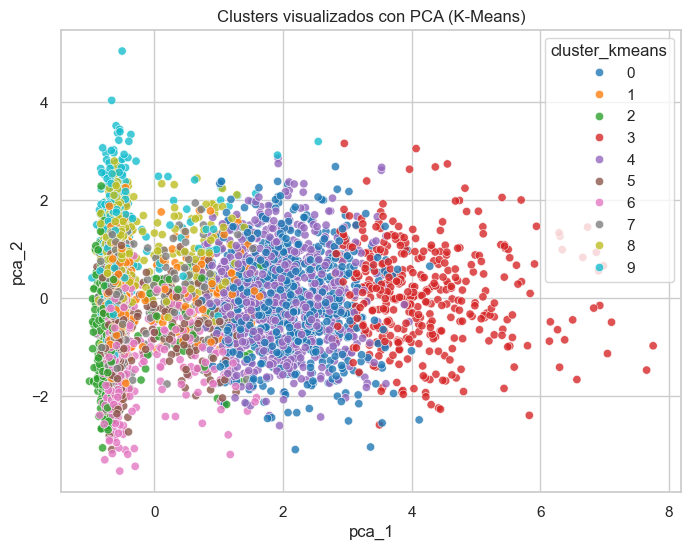

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducción a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

features_por_vuelo['pca_1'] = X_pca[:, 0]
features_por_vuelo['pca_2'] = X_pca[:, 1]

# Visualización por K-Means
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='cluster_kmeans',
    palette='tab10',
    data=features_por_vuelo,
    legend='full',
    alpha=0.8
)
plt.title("Clusters visualizados con PCA (K-Means)")
plt.grid(True)
plt.show()


### t-SNE

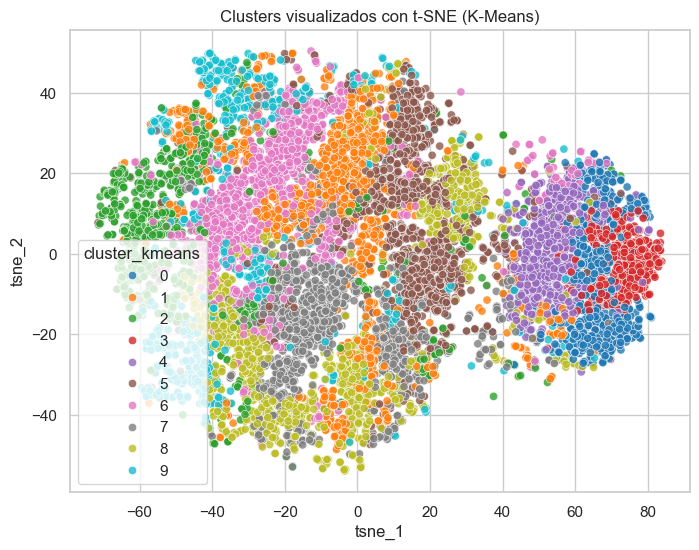

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

features_por_vuelo['tsne_1'] = X_tsne[:, 0]
features_por_vuelo['tsne_2'] = X_tsne[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='cluster_kmeans',  # Se puede cambiar para otro cluster
    palette='tab10',
    data=features_por_vuelo,
    legend='full',
    alpha=0.8
)
plt.title("Clusters visualizados con t-SNE (K-Means)")
plt.grid(True)
plt.show()


### Comparación cruzada de agrupamientos

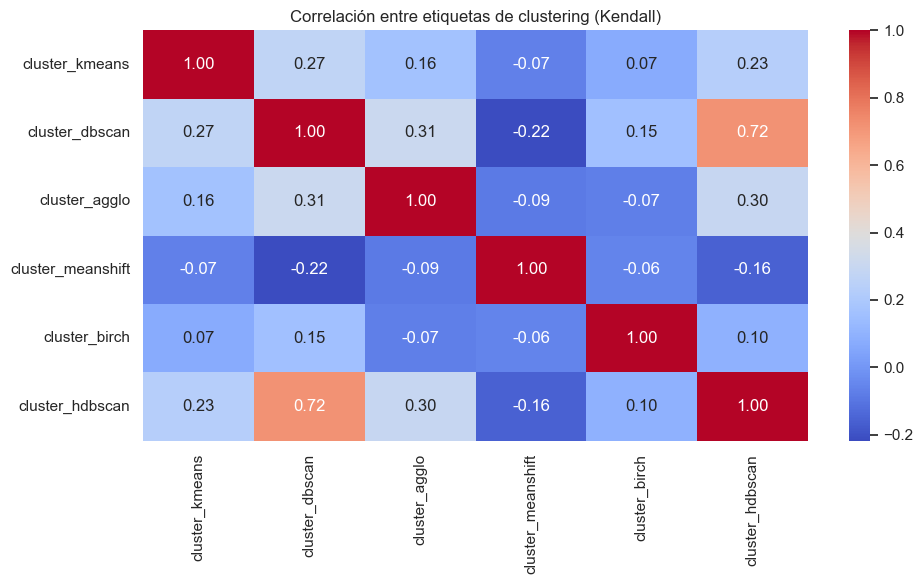

In [35]:
# Matriz de comparación entre algoritmos
import seaborn as sns
import matplotlib.pyplot as plt

algorithms = [col for col in features_por_vuelo.columns if col.startswith("cluster_")]

# Crear matriz de correlación de clusters
cluster_matrix = features_por_vuelo[algorithms].corr(method='kendall')

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre etiquetas de clustering (Kendall)")
plt.tight_layout()
plt.show()


In [38]:
# Resumen de tamaños por cluster
for alg in algorithms:
    print(f"\nDistribución de {alg}:")
    print(features_por_vuelo[alg].value_counts().sort_index())



Distribución de cluster_kmeans:
cluster_kmeans
0     632
1    1321
2     852
3     397
4     699
5    1301
6    1287
7    1308
8    1371
9     832
Name: count, dtype: int64

Distribución de cluster_dbscan:
cluster_dbscan
-1    2090
 0    7891
 1       6
 2      13
Name: count, dtype: int64

Distribución de cluster_agglo:
cluster_agglo
0    1571
1    2044
2    1873
3    1658
4    1726
5    1128
Name: count, dtype: int64

Distribución de cluster_meanshift:
cluster_meanshift
0    9875
1      35
2      90
Name: count, dtype: int64

Distribución de cluster_birch:
cluster_birch
0    2250
1    2071
2    2415
3     948
4    1460
5     856
Name: count, dtype: int64

Distribución de cluster_hdbscan:
cluster_hdbscan
-1    3315
 0      22
 1    6663
Name: count, dtype: int64


In [37]:
# Generar resumen tipo informe
from IPython.display import Markdown, display

def cluster_summary(df, label_column):
    resumen = df[label_column].value_counts().sort_index()
    resumen_text = f"## Informe para `{label_column}`\n"
    resumen_text += f"Se detectaron **{resumen.shape[0]} grupos** con la siguiente distribución:\n\n"
    for cluster, count in resumen.items():
        resumen_text += f"- Cluster {cluster}: {count} vuelos\n"
    return resumen_text

# Generar informe para todos los algoritmos
for alg in algorithms:
    display(Markdown(cluster_summary(features_por_vuelo, alg)))


## Informe para `cluster_kmeans`
Se detectaron **10 grupos** con la siguiente distribución:

- Cluster 0: 632 vuelos
- Cluster 1: 1321 vuelos
- Cluster 2: 852 vuelos
- Cluster 3: 397 vuelos
- Cluster 4: 699 vuelos
- Cluster 5: 1301 vuelos
- Cluster 6: 1287 vuelos
- Cluster 7: 1308 vuelos
- Cluster 8: 1371 vuelos
- Cluster 9: 832 vuelos


## Informe para `cluster_dbscan`
Se detectaron **4 grupos** con la siguiente distribución:

- Cluster -1: 2090 vuelos
- Cluster 0: 7891 vuelos
- Cluster 1: 6 vuelos
- Cluster 2: 13 vuelos


## Informe para `cluster_agglo`
Se detectaron **6 grupos** con la siguiente distribución:

- Cluster 0: 1571 vuelos
- Cluster 1: 2044 vuelos
- Cluster 2: 1873 vuelos
- Cluster 3: 1658 vuelos
- Cluster 4: 1726 vuelos
- Cluster 5: 1128 vuelos


## Informe para `cluster_meanshift`
Se detectaron **3 grupos** con la siguiente distribución:

- Cluster 0: 9875 vuelos
- Cluster 1: 35 vuelos
- Cluster 2: 90 vuelos


## Informe para `cluster_birch`
Se detectaron **6 grupos** con la siguiente distribución:

- Cluster 0: 2250 vuelos
- Cluster 1: 2071 vuelos
- Cluster 2: 2415 vuelos
- Cluster 3: 948 vuelos
- Cluster 4: 1460 vuelos
- Cluster 5: 856 vuelos


## Informe para `cluster_hdbscan`
Se detectaron **3 grupos** con la siguiente distribución:

- Cluster -1: 3315 vuelos
- Cluster 0: 22 vuelos
- Cluster 1: 6663 vuelos
